In [146]:
import csv, pandas as pd, matplotlib.pyplot as plt, numpy as np

In [5]:
# Download PPI data
!wget -N -P data/ https://reactome.org/download/current/interactors/reactome.homo_sapiens.interactions.tab-delimited.txt

--2022-10-14 15:58:20--  https://reactome.org/download/current/interactors/reactome.homo_sapiens.interactions.tab-delimited.txt
Resolving reactome.org (reactome.org)... 100.25.71.177
Connecting to reactome.org (reactome.org)|100.25.71.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42957404 (41M) [text/plain]
Saving to: ‘data/reactome.homo_sapiens.interactions.tab-delimited.txt’

reactome.homo_sapie 100%[===================>]  40.97M  17.5MB/s    in 2.3s    

2022-10-14 15:58:23 (17.5 MB/s) - ‘data/reactome.homo_sapiens.interactions.tab-delimited.txt’ saved [42957404/42957404]



In [147]:
'''Read in Protein-Protein Interaction (PPI) table data'''
ppi_table = pd.read_table('data/reactome.homo_sapiens.interactions.tab-delimited.txt')
protein2protein = dict()
ppi2pubmed = dict()
pubmed2ppi = dict()

with open('data/reactome_ppi.csv','w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Protein 1','Protein 2','Reaction Context','Interaction Type','PubMed References'])
    
    for i in range(0, len(ppi_table)):
        # Get PPI
        protein_1 = ppi_table['# Interactor 1 uniprot id'].iloc[i]
        protein_2 = ppi_table['Interactor 2 uniprot id'].iloc[i]
        if 'uniprotkb' in protein_1 and 'uniprotkb' in protein_2:
            protein_1 = protein_1.split(':')[1]
            protein_2 = protein_2.split(':')[1]
            protein2protein.setdefault(protein_1, set()).add(protein_2)
            protein2protein.setdefault(protein_2, set()).add(protein_1)
            reaction = ppi_table['Interaction context'].iloc[i]
            interaction_type = ppi_table['Interaction type'].iloc[i]
            pubmed_refs = ppi_table['Pubmed references'].iloc[i]
            writer.writerow([protein_1, protein_2, reaction, interaction_type, pubmed_refs])

            # Get PPI-PMIDs
            if type(pubmed_refs) == str:
                pubmed_refs = pubmed_refs.split('|')
                for pubmed_ref in pubmed_refs:
                    ppi2pubmed.setdefault(str(protein_1+protein_2), set()).add(pubmed_ref)  
                    pubmed2ppi.setdefault(pubmed_ref, set()).add(str(protein_1+protein_2))
            else:
                 ppi2pubmed.setdefault(str(protein_1+protein_2), set())      
                    
    
                    
ppi_df = pd.read_csv(open('data/reactome_ppi.csv'))

alleged_proteins = set(ppi_table['# Interactor 1 uniprot id']).union(ppi_table['Interactor 2 uniprot id'])
reaction2count = dict(ppi_df.value_counts('Reaction Context'))

# Get count of PPI-PubMed
ppi2num_pubmed = dict()
for ppi, pubmeds in ppi2pubmed.items():
    count = len(pubmeds)
    ppi2num_pubmed[ppi] = ppi2num_pubmed.get(ppi, 0) + count
ppi2num_pubmed = dict(sorted(ppi2num_pubmed.items(), key = lambda x:x[1], reverse=True))

In [148]:
'''Reactome Reaction ID -> Name'''
# Data taken from the Reactome Neo4j Graph data https://reactome.org/download-data/
reaction_df = pd.read_csv('../../Drug Repurposing Knowledge Graph/input/human_reaction-like_events.csv')[['stId','displayName','category']].drop_duplicates()

reaction_id2name = dict()

for i in range(0,len(reaction_df)):
    reaction_id = reaction_df['stId'].iloc[i]
    name = reaction_df['displayName'].iloc[i]
    category = reaction_df['category'].iloc[i]
    
    if type(name) != str:
        continue
    name += ' '+category
    
    reaction_id2name.setdefault(reaction_id, list()).append(name)
    
    
reaction_name2count = dict()
for reaction_id, count in reaction2count.items():
    reaction_id = reaction_id.split(':')[1]
    try:
        reaction_name = list(reaction_id2name[reaction_id])[0]
        reaction_name2count[reaction_name] = count
    except:
        pass

In [149]:
'''Protein Info'''
print(len(alleged_proteins), 'entities in the PPI')
print(len(protein2protein), 'proteins in the PPI')
print(len(ppi_df), 'proteins in the PPI')

8787 entities in the PPI
5616 proteins in the PPI
69677 proteins in the PPI


In [150]:
# PPI types
print(ppi_df.value_counts('Interaction Type'))

Interaction Type
physical association                                  62990
enzymatic reaction                                     4675
cleavage reaction                                      1195
dephosphorylation reaction                              405
oxidoreductase activity electron transfer reaction      100
acetylation reaction                                     80
glycosylation reaction                                   43
gtpase reaction                                          41
nucleoside triphosphatase reaction                       37
phospholipase reaction                                   34
deubiquitination reaction                                15
carboxylation reaction                                   15
demethylation reaction                                   13
deacetylation reaction                                   13
amidation reaction                                        9
deneddylation reaction                                    6
sulfurtransfer reaction

In [153]:
# PPI Reaction Contexts
display(reaction_name2count)

{'Phosphorylation of ZAP-70 by Lck transition': 306,
 'Conversion of C4 into C4a and C4b transition': 147,
 'p-AMPK:AMP phosphorylates Raptor in the MTORC1 complex transition': 91,
 'Phosphorylation of PLC-gamma1 transition': 88,
 'EXO1 or DNA2 in complex with BLM or WRN binds initially resected DNA DSBs along with BRIP1 recruitment binding': 87,
 'RAB6:GTP displaces PAFAH1B1 from dynein:dynactin complex transition': 80,
 'ULK1 phosphorylates AMBRA1:BECN1 complex transition': 77,
 'RAS guanyl-nucleotide exchange mediated by SOS1 in complex with GRB2 and p-SHC1:Phosphorylated ERBB2 heterodimers transition': 76,
 'CDT1-mediated formation of MCM2-7 double hexamer at the replication origin transition': 76,
 'MAP2Ks and MAPKs bind to the activated mutant RAF1 complex binding': 72,
 'AMPK phosphorylates Raptor in the mTORC1 complex transition': 63,
 'ERBB2 forms heterodimers with ligand-activated ERBB receptors: EGFR, ERBB3 and ERBB4 dissociation': 62,
 'Gab2 binds the p85 subunit of Class 1

1 min PPIs per reaction
306 max PPIs per reaction
5.840272520817562 average PPIs per reaction
3.0 median PPIs per reaction


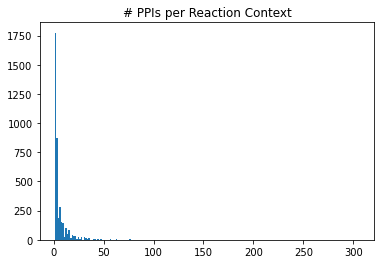

In [154]:
plt.title('# PPIs per Reaction Context');
plt.hist(list(reaction_name2count.values()), bins = 200);
print(min(list(reaction_name2count.values())), 'min PPIs per reaction')
print(max(list(reaction_name2count.values())), 'max PPIs per reaction')
print(np.mean(list(reaction_name2count.values())), 'average PPIs per reaction')
print(np.median(list(reaction_name2count.values())),'median PPIs per reaction')

10851 PubMed articles used as sources
26224 PPIs with PubMed articles used as sources
43453 PPIs without PubMed articles as sources


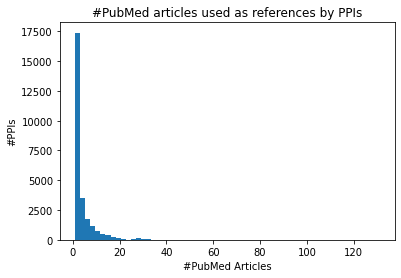

In [161]:
'''PubMed References per PPI'''
print(len(pubmed2ppi), 'PubMed articles used as sources')
print(len(ppi2pubmed), 'PPIs with PubMed articles used as sources')
print(len(ppi_df) - len(ppi2pubmed), 'PPIs without PubMed articles as sources')
plt.title('#PubMed articles used as references by PPIs')
plt.xlabel('#PubMed Articles')
plt.ylabel('#PPIs')
plt.hist(ppi2num_pubmed.values(),bins=60);